In [1]:
import pandas as pd
import psycopg2
import psycopg2.extras

In [21]:
from sklearn.preprocessing import LabelEncoder

In [184]:
select_query = "select model, postdate, topic, brand from forumposts where topic not in ('no match')"

In [185]:
def db_connect():
    connection = psycopg2.connect(
        host="autosense-1.ciqghxikd2ck.us-east-1.rds.amazonaws.com",
        database="postgres",
        user='postgres',
        password='AutoSense123?'
    )

    return connection

In [186]:
connection = db_connect()
cursor = connection.cursor(cursor_factory = psycopg2.extras.RealDictCursor)

cursor.execute(select_query)
data = cursor.fetchall()

In [187]:
cursor.close()
connection.close()

In [188]:
df = pd.DataFrame(data)

In [189]:
df.head()

,model,postdate,topic,brand
0,Q8 e-tron (GE) ab 2018,2021-10-23,Zentralverriegelung,Audi
1,Q8 e-tron (GE) ab 2018,2020-03-17,Dachträger und Dachboxen,Audi
2,Q8 e-tron (GE) ab 2018,2020-01-22,Schiebedach Probleme,Audi
3,Q8 e-tron (GE) ab 2018,2019-05-29,Zentralverriegelung,Audi
4,Q8 e-tron (GE) ab 2018,2019-06-26,Zentralverriegelung,Audi


In [190]:
model_encoder = LabelEncoder()
df['model_id'] = model_encoder.fit_transform(df['model'])

In [191]:
model_encoder.inverse_transform([8])

array(['F4 ab 2021'], dtype=object)

In [192]:
model_encoder.classes_

array(['115, 916, 960, 961, ab 1966',
       '164, 167, 930, 932, 936, 937, 1988-2010', '1972-1995',
       '939, 940, 955, ab 2005', '949, 952, ab 2016', 'AA, ab 2013',
       'AU, ab 2014', 'Alles zum ersten reinen Elektroauto aus München',
       'F4 ab 2021', 'Forum für Youngtimer & Oldtimer aller Marken',
       'G08 ab 2021', 'ID.3, ID.4 ab 2020', 'Q8 e-tron (GE) ab 2018',
       'U11 ab 2023', 'i20 ab 2021'], dtype=object)

In [193]:
df[df['model_id']==0]

,model,postdate,topic,brand,model_id
79,"115, 916, 960, 961, ab 1966",2008-05-10,Schiebedach Probleme,Alfa Romeo,0
80,"115, 916, 960, 961, ab 1966",2013-02-16,Reifen und Felgen,Alfa Romeo,0


In [194]:
def augment_data(row):
    augmented_data = []
    augmented_data.append(row)
    
    if row['model_id'] == 2:
        rows_to_augment = 5
    elif row['model_id'] == 12:
        rows_to_augment = 10
    else:
        rows_to_augment = 40
        
    for _ in range(rows_to_augment):
        augmented_row = row.copy()
        augmented_data.append(augmented_row)
    
    return augmented_data

In [195]:
augmented_data = []
for _, row in df.iterrows():
    augmented_records = augment_data(row)
    augmented_data.extend(augmented_records)


In [196]:
augmented_df = pd.DataFrame(augmented_data)

In [197]:
len(augmented_df)

14247

In [198]:
len(df)

1157

<Axes: xlabel='model_id'>

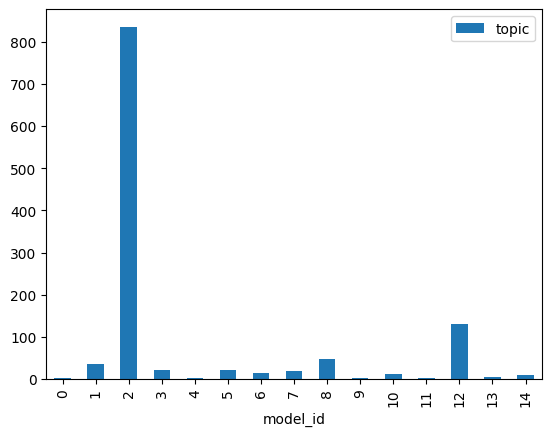

In [199]:
df[['topic', 'model_id']].groupby(by=['model_id']).count().plot.bar()

<Axes: xlabel='model_id'>

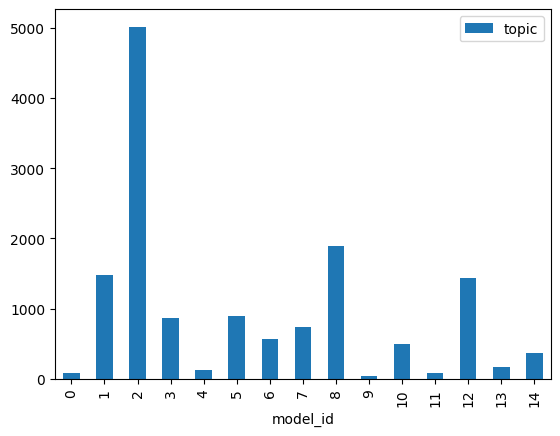

In [200]:
augmented_df[['topic', 'model_id']].groupby(by=['model_id']).count().plot.bar()

<Axes: xlabel='topic'>

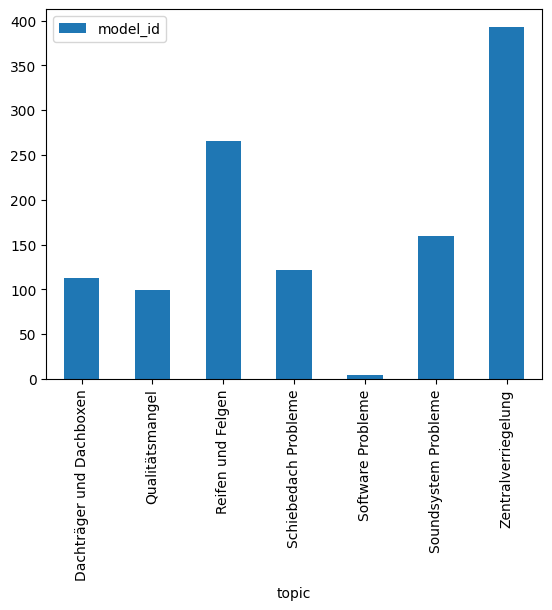

In [201]:
df[['topic', 'model_id']].groupby(by=['topic']).count().plot.bar()

<Axes: xlabel='topic'>

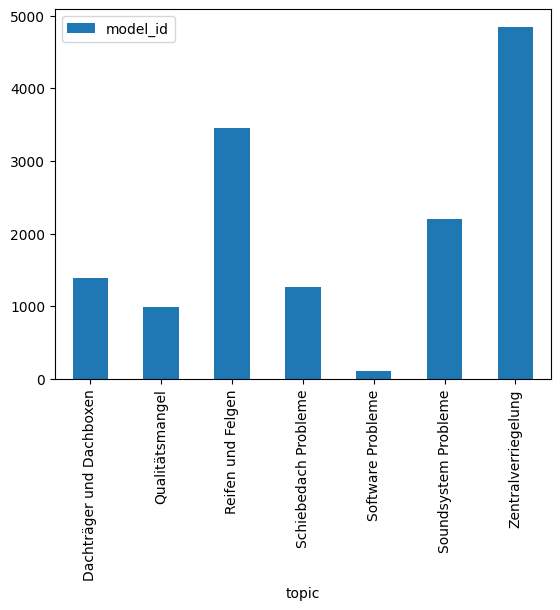

In [202]:
augmented_df[['topic', 'model_id']].groupby(by=['topic']).count().plot.bar()

## Forecasting

In [118]:
from statsmodels.tsa.arima.model import ARIMA

In [159]:
temp_df = augmented_df.copy()

In [160]:
temp_df['postdate'] = pd.to_datetime(temp_df['postdate'])

In [161]:
temp_df = temp_df[temp_df['postdate'] < '2023-06-30']

In [162]:
temp_df = temp_df[temp_df['model_id'] == 8]

In [163]:
quarter_counts = temp_df.groupby(pd.Grouper(key='postdate', freq='Q')).size()

In [164]:
quarter_counts 

postdate
2021-06-30     82
2021-09-30      0
2021-12-31     82
2022-03-31    287
2022-06-30    205
2022-09-30     82
2022-12-31    205
2023-03-31    492
2023-06-30    451
Freq: Q-DEC, dtype: int64

In [165]:
quarter_index = pd.date_range(start=quarter_counts.index[0], periods=len(quarter_counts), freq='Q')

In [166]:
quarter_index

DatetimeIndex(['2021-06-30', '2021-09-30', '2021-12-31', '2022-03-31',
               '2022-06-30', '2022-09-30', '2022-12-31', '2023-03-31',
               '2023-06-30'],
              dtype='datetime64[ns]', freq='Q-DEC')

In [167]:
model = ARIMA(quarter_counts, order=(2, 2, 1))

In [168]:
model_fit = model.fit()

In [169]:
future_quarters = 8  # Number of future quarters to forecast
forecast = model_fit.forecast(steps=future_quarters)

In [170]:
forecast

2023-09-30    263.367943
2023-12-31    375.976315
2024-03-31    628.993837
2024-06-30    607.285775
2024-09-30    451.343418
2024-12-31    546.682708
2025-03-31    770.160814
2025-06-30    763.891253
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [173]:
connection = db_connect()
cursor = connection.cursor(cursor_factory = psycopg2.extras.RealDictCursor)

cursor.execute('select distinct model, brand from forumposts')
model_brand = cursor.fetchall()

In [176]:
model_brand = pd.DataFrame(model_brand)

In [179]:
model_brand = dict(model_brand[['model', 'brand']].values)

In [180]:
model_brand

{'164, 167, 930, 932, 936, 937, 1988-2010': 'Alfa Romeo',
 'G08 ab 2021': 'BMW',
 '1972-1995': 'Audi',
 'i20 ab 2021': 'BMW',
 '939, 940, 955, ab 2005': 'Alfa Romeo',
 'Forum für Youngtimer & Oldtimer aller Marken': 'Audi',
 'ID.3, ID.4 ab 2020': 'Volkswagen',
 'Alles zum ersten reinen Elektroauto aus München': 'BMW',
 '115, 916, 960, 961, ab 1966': 'Alfa Romeo',
 '949, 952, ab 2016': 'Alfa Romeo',
 'Q8 e-tron (GE) ab 2018': 'Audi',
 'F4 ab 2021': 'Audi',
 'U11 ab 2023': 'BMW',
 'AU, ab 2014': 'Volkswagen',
 'Autogas (LPG), Erdgas (CNG)': 'Audi',
 'AA, ab 2013': 'Volkswagen'}

In [181]:
augmented_df['brand'] = augmented_df.model.map(model_brand)

In [ ]:
data.to_sql('book_details', con = engine, if_exists = 'append', chunksize = 1000)

In [204]:
augmented_df = augmented_df.drop(columns=['model_id'])

In [207]:
connection = db_connect()

In [208]:
augmented_df.to_sql('forumposts', con = connection)

/tmp/ipykernel_46216/2587430919.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  augmented_df.to_sql('forumposts', con = connection)


DatabaseError: Execution failed on sql 'SELECT name FROM sqlite_master WHERE type='table' AND name=?;': syntax error at or near ";"
LINE 1: ...ELECT name FROM sqlite_master WHERE type='table' AND name=?;
                                                                      ^


In [213]:
cursor = connection.cursor()
cursor.-('insert into ForumPosts(model, postdate, brand, topic) values(%s, %s, %s, %s)', 
                  [(row.model, row.postdate, row.brand, row.topic) for _, row in augmented_df.iterrows()])

In [214]:
cursor.close()
connection.commit()